# Neural networks with PyTorch

Deep learning networks tend to be massive with dozens or hundreds of layers, that's where the term "deep" comes from. You can build one of these deep networks using only weight matrices as we did in the previous notebook, but in general it's very cumbersome and difficult to implement. PyTorch has a nice module `nn` that provides a nice way to efficiently build large neural networks.

In [5]:
# Import necessary packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import matplotlib.pyplot as plt
import torch

In [4]:
# setup for running within the project structure
import sys
from pathlib import Path
from dotenv import load_dotenv
import os

# Load environment variables from .env
load_dotenv()

# Add project src to path
project_src = os.getenv('PROJECT_SRC')
if project_src and project_src not in sys.path:
    sys.path.insert(0, project_src)

# Now you can import from your package
import matplotlib.pyplot as plt
import torch
from corrupt_mnist.data import corrupt_mnist


Now we're going to build a larger network that can solve a (formerly) difficult problem, identifying text in an image. Here we'll use a CORRUPTED version MNIST dataset which consists of greyscale handwritten digits. Each image is 28x28 pixels, and contains digits 0-9.

Our goal is to build a neural network that can take one of these images and predict the digit in the image.

First up, we need to get our dataset. This is provided through the `torchvision` package. The code below will download the MNIST dataset, then create training and test datasets for us. Don't worry too much about the details here, you'll learn more about this later.

In [ ]:
### Run this cell to load the data ###

# Find the data path relative to the current working directory
# If running from project root: /data/
# If running from notebooks folder: ../data/
cwd = Path(os.getcwd())
if (cwd / 'data').exists():
    data_path = cwd / 'data'
else:
    data_path = cwd.parent / 'data'

print(f"Loading data from: {data_path}")

# Download and load the training data
trainset, testset = corrupt_mnist(data_path=data_path)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Loading data from: /Users/brunozorrilla/Documents/GitHub/corrupt-mnist/data


We have the training data loaded into `trainloader` and we make that an iterator with `iter(trainloader)`. Later, we'll use this to loop through the dataset for training, like

```python
for image, label in trainloader:
    ## do things with images and labels
```

You'll notice I created the `trainloader` with a batch size of 64, and `shuffle=True`. The batch size is the number of images we get in one iteration from the data loader and pass through our network, often called a *batch*. And `shuffle=True` tells it to shuffle the dataset every time we start going through the data loader again. But here I'm just grabbing the first batch so we can check out the data. We can see below that `images` is just a tensor with size `(64, 1, 28, 28)`. So, 64 images per batch, 1 color channel, and 28x28 images.

In [11]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


This is what one of the images looks like. 

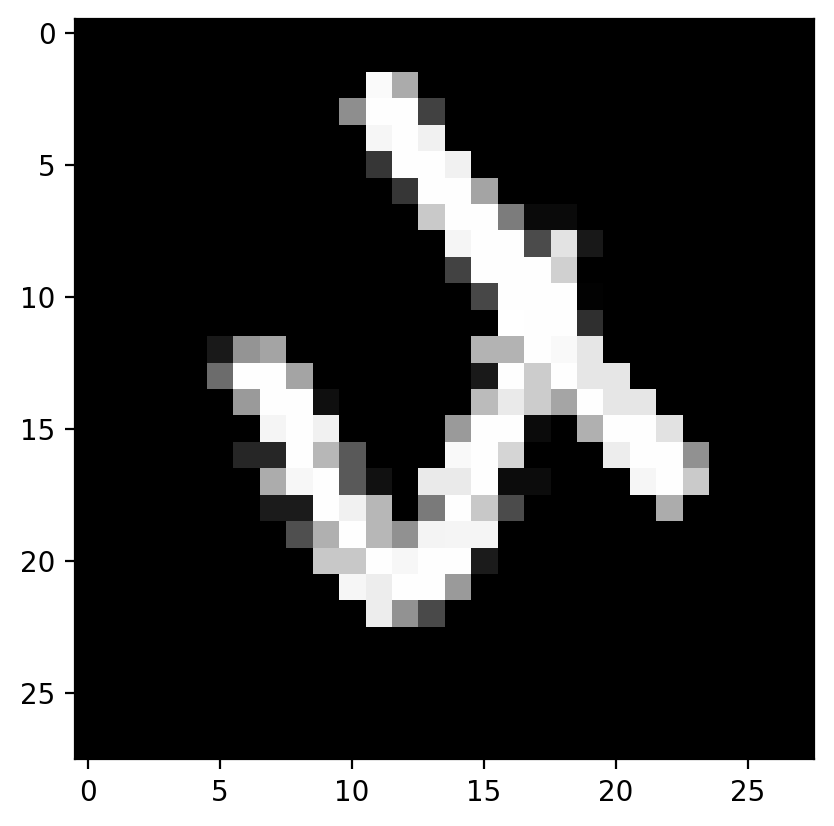

In [14]:
plt.imshow(images[63].numpy().squeeze(), cmap="Greys_r");

## Building networks with PyTorch

PyTorch provides a module `nn` that makes building networks much simpler. Here I'll show you how to build the same one as above with 784 inputs, 256 hidden units, 10 output units and a softmax output.

In [19]:
from torch import nn

In [23]:
class Network(nn.Module):
    """Basic Neural Network with 1 hidden layer."""

    def __init__(self) -> None:
        super().__init__()

        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)

        # Define sigmoid activation and softmax output
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        """Forward pass through the network, returns the output logits."""
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        return self.softmax(x)

Let's go through this bit by bit.

```python
class Network(nn.Module):
```

Here we're inheriting from `nn.Module`. Combined with `super().__init__()` this creates a class that tracks the architecture and provides a lot of useful methods and attributes. It is mandatory to inherit from `nn.Module` when you're creating a class for your network. The name of the class itself can be anything.

```python
self.hidden = nn.Linear(784, 256)
```

This line creates a module for a linear transformation, $x\mathbf{W} + b$, with 784 inputs and 256 outputs and assigns it to `self.hidden`. The module automatically creates the weight and bias tensors which we'll use in the `forward` method. You can access the weight and bias tensors once the network (`net`) is created with `net.hidden.weight` and `net.hidden.bias`.

```python
self.output = nn.Linear(256, 10)
```

Similarly, this creates another linear transformation with 256 inputs and 10 outputs.

```python
self.sigmoid = nn.Sigmoid()
self.softmax = nn.Softmax(dim=1)
```

Here I defined operations for the sigmoid activation and softmax output. Setting `dim=1` in `nn.Softmax(dim=1)` calculates softmax across the columns.

```python
def forward(self, x):
```

PyTorch networks created with `nn.Module` must have a `forward` method defined. It takes in a tensor `x` and passes it through the operations you defined in the `__init__` method.

```python
x = self.hidden(x)
x = self.sigmoid(x)
x = self.output(x)
x = self.softmax(x)
```

Here the input tensor `x` is passed through each operation and reassigned to `x`. We can see that the input tensor goes through the hidden layer, then a sigmoid function, then the output layer, and finally the softmax function. It doesn't matter what you name the variables here, as long as the inputs and outputs of the operations match the network architecture you want to build. The order in which you define things in the `__init__` method doesn't matter, but you'll need to sequence the operations correctly in the `forward` method.

Now we can create a `Network` object.

In [24]:
# Create the network and look at its text representation
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

You can define the network somewhat more concisely and clearly using the `torch.nn.functional` module. This is the most common way you'll see networks defined as many operations are simple element-wise functions. We normally import this module as `F`, `import torch.nn.functional as F`.

In [25]:
from torch.nn.functional import sigmoid, softmax


class Network(nn.Module):
    """Basic Neural Network with 1 hidden layer."""

    def __init__(self) -> None:
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)

    def forward(self, x):
        """Forward pass through the network, returns the output logits."""
        # Hidden layer with sigmoid activation
        x = sigmoid(self.hidden(x))
        # Output layer with softmax activation
        return softmax(self.output(x), dim=1)

### Activation functions

So far we've only been looking at the sigmoid activation function, but in general any function can be used as an activation function. The only requirement is that for a network to approximate a non-linear function, the activation functions must be non-linear. Here are a few more examples of common activation functions: Tanh (hyperbolic tangent), and ReLU (rectified linear unit).

In practice, the ReLU function is used almost exclusively as the activation function for hidden layers.

### Your Turn to Build a Network

<img src="assets/mlp_mnist.png" width=600px>

> **Exercise:** Create a network with 784 input units, a hidden layer with 128 units and a ReLU activation, then a hidden layer with 64 units and a ReLU activation, and finally an output layer with a softmax activation as shown above. You can use a ReLU activation with the `nn.ReLU` module or `F.relu` function.

It's good practice to name your layers by their type of network, for instance 'fc' to represent a fully-connected layer. As you code your solution, use `fc1`, `fc2`, and `fc3` as your layer names.

In [27]:
import torch.nn.functional as F

class Network(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):

        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = F.softmax(x, dim=1)

        return x
        

model = Network()

### Initializing weights and biases

The weights and such are automatically initialized for you, but it's possible to customize how they are initialized. The weights and biases are tensors attached to the layer you defined, you can get them with `model.fc1.weight` for instance.

In [48]:
print(model.fc1.weight)
print(model.fc1.bias)

Parameter containing:
tensor([[ 2.0301e-02, -2.2908e-02, -1.3610e-02,  ..., -1.0326e-02,
          1.4115e-02,  4.5507e-03],
        [ 1.1343e-02,  7.7626e-03, -2.2832e-02,  ..., -3.1612e-03,
         -8.7112e-03,  2.3355e-02],
        [ 2.4351e-02,  4.8196e-03,  6.7487e-03,  ...,  3.2356e-02,
         -9.7267e-03, -7.3080e-03],
        ...,
        [ 2.3499e-04, -2.8253e-05,  3.1488e-02,  ...,  1.0078e-02,
          1.0189e-02, -6.2284e-03],
        [-2.1987e-02,  8.4202e-03, -3.5530e-02,  ..., -2.1676e-02,
          3.4304e-02, -4.0577e-03],
        [ 3.0635e-02, -4.2005e-03, -2.7742e-03,  ..., -1.9203e-03,
         -1.4071e-02,  1.5258e-02]], requires_grad=True)
Parameter containing:
tensor([ 0.0030, -0.0200,  0.0012,  0.0268, -0.0011,  0.0057,  0.0021,  0.0332,
        -0.0277,  0.0091,  0.0286,  0.0255,  0.0179, -0.0138, -0.0297, -0.0277,
        -0.0065, -0.0195,  0.0068, -0.0190, -0.0104,  0.0117, -0.0306, -0.0336,
         0.0178, -0.0255, -0.0196,  0.0228,  0.0129,  0.0247, -0

For custom initialization, we want to modify these tensors in place. These are actually autograd *Variables*, so we need to get back the actual tensors with `model.fc1.weight.data`. Once we have the tensors, we can fill them with zeros (for biases) or random normal values.

In [49]:
# Set biases to all zeros
model.fc1.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [50]:
# sample from random normal with standard dev = 0.01
model.fc1.weight.data.normal_(std=0.01)

tensor([[ 1.4911e-02,  4.6114e-04,  3.9718e-05,  ...,  1.1299e-02,
         -8.9768e-03, -7.3175e-03],
        [-4.1940e-03, -9.9729e-03, -5.2461e-03,  ..., -2.1867e-03,
          1.6949e-02,  9.4025e-03],
        [ 3.3022e-03,  1.1017e-02, -8.8136e-03,  ..., -5.0033e-03,
         -5.9111e-03,  4.6520e-03],
        ...,
        [-2.7153e-03, -1.0109e-02,  1.3177e-02,  ..., -2.1480e-02,
         -1.2059e-02, -7.9035e-03],
        [ 3.0175e-03, -8.3859e-03,  1.3279e-02,  ..., -7.3077e-03,
          4.5389e-03, -9.0819e-03],
        [-3.6801e-04,  1.5904e-03,  7.5264e-03,  ...,  1.0128e-02,
          8.5871e-03, -4.0077e-03]])

### Forward pass

Now that we have a network, let's see what happens when we pass in an image.

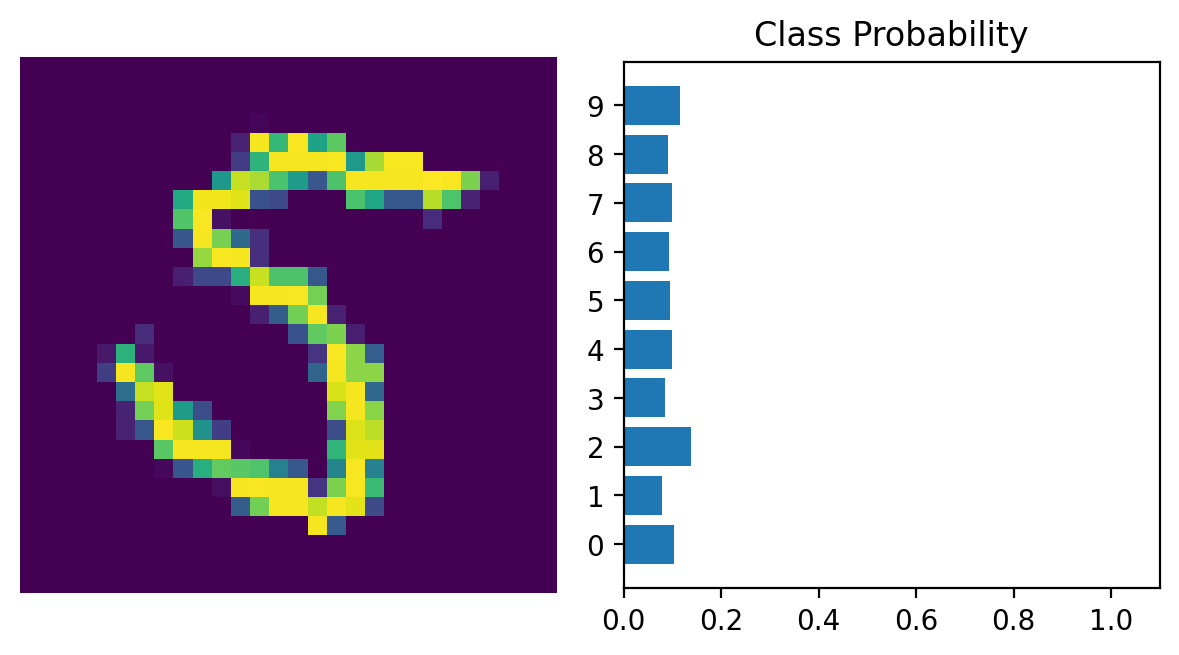

In [ ]:
# Grab some data
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Resize images into a 1D vector, new shape is (batch size = 64, color channels = 1, image pixels = 784)
images.resize_(64, 1, 784)
# or images.resize_(images.shape[0], 1, 784) to automatically get batch size

# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx, :])

img = images[img_idx]
helper.view_classify(img.view(1, 28, 28), ps)

As you can see above, our network has basically no idea what this digit is. It's because we haven't trained it yet, all the weights are random!

### Using `nn.Sequential`

PyTorch provides a convenient way to build networks like this where a tensor is passed sequentially through operations, `nn.Sequential` ([documentation](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential)). Using this to build the equivalent network:

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=1)
)


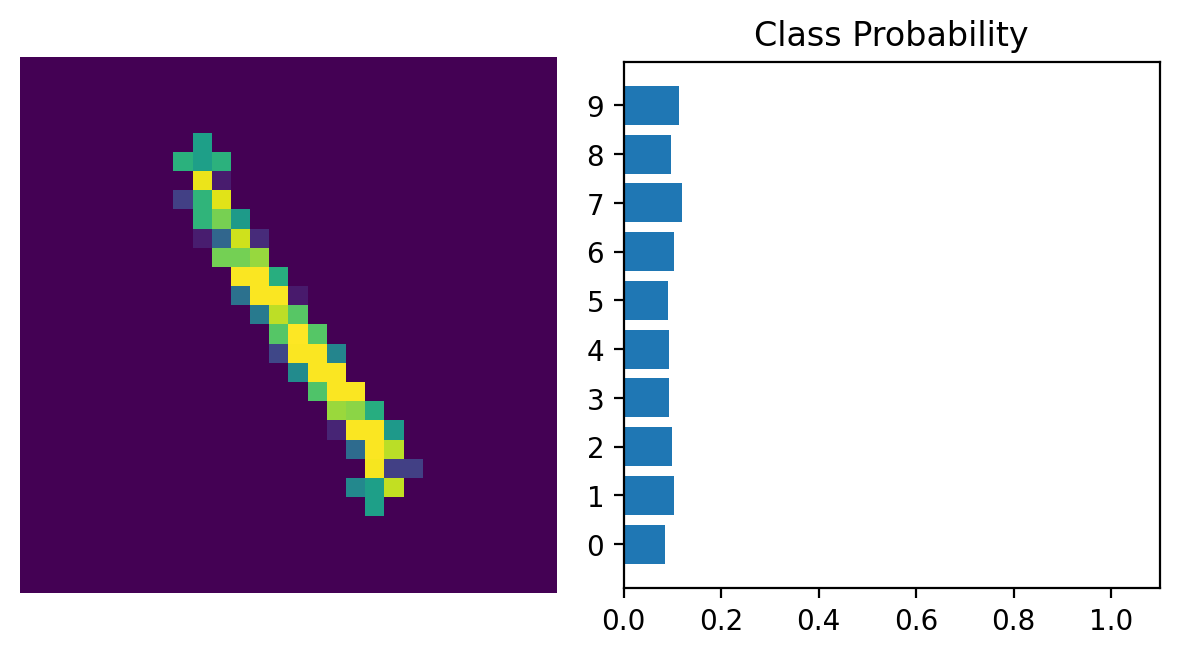

In [29]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[1], output_size),
    nn.Softmax(dim=1),
)
print(model)

# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0, :])
helper.view_classify(images[0].view(1, 28, 28), ps)

Here our model is the same as before: 784 input units, a hidden layer with 128 units, ReLU activation, 64 unit hidden layer, another ReLU, then the output layer with 10 units, and the softmax output.

The operations are available by passing in the appropriate index. For example, if you want to get first Linear operation and look at the weights, you'd use `model[0]`.

In [57]:
print(model[0])
model[0].weight

Linear(in_features=784, out_features=128, bias=True)


Parameter containing:
tensor([[-0.0062,  0.0256, -0.0301,  ...,  0.0081, -0.0226, -0.0134],
        [-0.0349,  0.0082,  0.0119,  ...,  0.0138, -0.0258, -0.0066],
        [-0.0203,  0.0115, -0.0324,  ..., -0.0013, -0.0137, -0.0217],
        ...,
        [ 0.0074,  0.0353,  0.0350,  ..., -0.0011,  0.0343, -0.0193],
        [ 0.0273, -0.0190,  0.0089,  ...,  0.0118,  0.0197, -0.0335],
        [ 0.0275,  0.0330, -0.0348,  ..., -0.0149,  0.0329, -0.0333]],
       requires_grad=True)

You can also pass in an `OrderedDict` to name the individual layers and operations, instead of using incremental integers. Note that dictionary keys must be unique, so _each operation must have a different name_.

In [30]:
from collections import OrderedDict

model = nn.Sequential(
    OrderedDict(
        [
            ("fc1", nn.Linear(input_size, hidden_sizes[0])),
            ("relu1", nn.ReLU()),
            ("fc2", nn.Linear(hidden_sizes[0], hidden_sizes[1])),
            ("relu2", nn.ReLU()),
            ("output", nn.Linear(hidden_sizes[1], output_size)),
            ("softmax", nn.Softmax(dim=1)),
        ],
    ),
)
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

Now you can access layers either by integer or the name

In [59]:
print(model[0])
print(model.fc1)

Linear(in_features=784, out_features=128, bias=True)
Linear(in_features=784, out_features=128, bias=True)


In the next notebook, we'll see how we can train a neural network to accuractly predict the numbers appearing in the MNIST images.